Load dataset and scale

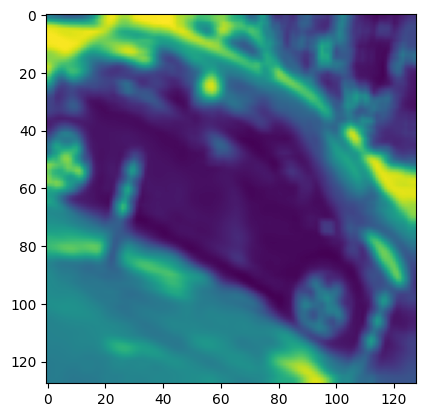

Number of images 1310


In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

dataset_path = "./dataset"
vehicle_types = ["hatchback", "motorcycle", "pickup", "sedan", "suv"]

image_x_size = 128
image_y_size = 128

images = pd.DataFrame(columns=["image", "type"])
blur_kernel = np.ones((5,5),np.float32)/25
for v_type in vehicle_types:
    for dirpath, dirnames, filenames in os.walk(dataset_path+"/"+v_type):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            image = cv2.imread(file_path)
            image = cv2.resize(image, (image_x_size, image_y_size))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = image / 255.0
            image = cv2.filter2D(image,-1, blur_kernel)
            images.loc[len(images)] = {"image": image, "type": v_type}

plt.imshow(images.loc[0]["image"])
plt.show()
print(f"Number of images {len(images)}")
img_copy = images.copy(deep=True)

In [2]:
images = img_copy.copy(deep=True)

Feature extraction and selection

In [3]:
from skimage.feature import hog

# Hog features
def get_hog_features(row):
    '''
    The parameters for the HOG can be tuned to get better results if needed
    '''
    feature, _ = hog(row["image"].copy(),
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True,
        transform_sqrt=True
    )
    # plt.imshow(_)
    # plt.show()
    return pd.Series({
        "hog_features": feature
    })

images['hog_features'] = images.apply(get_hog_features, axis=1)
print(images.head(1))

# SIFT features
shift_step_size = 8
keypoints = [cv2.KeyPoint(x, y, shift_step_size)
             for y in range(0, image_y_size, shift_step_size)
             for x in range(0, image_x_size, shift_step_size)]
sift = cv2.SIFT_create()
def get_SIFT_descriptors(row):
    _, desc = sift.compute(cv2.convertScaleAbs(row["image"].copy() * 255.0), keypoints)
    return pd.Series({
        "sift_descriptors": desc
    })

images['sift_descriptors'] = images.apply(get_SIFT_descriptors, axis=1)
print(images.head(1))

img_feat_copy = images.copy(deep=True)

                                               image       type  \
0  [[0.45113724481825734, 0.4432941077386631, 0.4...  hatchback   

                                        hog_features  
0  [0.08343742388287498, 0.0, 0.0, 0.0, 0.4803709...  
                                               image       type  \
0  [[0.45113724481825734, 0.4432941077386631, 0.4...  hatchback   

                                        hog_features  \
0  [0.08343742388287498, 0.0, 0.0, 0.0, 0.4803709...   

                                    sift_descriptors  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  


In [4]:
images = img_feat_copy.copy(deep=True)

Split the data

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

data = images.drop(columns=["image", "type"])

encoder = OneHotEncoder(sparse_output=False)
encoder.set_output(transform="pandas") 
result = encoder.fit_transform(images["type"].to_frame())

train_data, test_data, train_validation, test_validation = train_test_split(data, result, test_size=0.2, random_state=23, stratify=result)

PCA

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# flattened_train = pd.DataFrame(columns=["hog_features", "sift_descriptors"])
# flattened_train['hog_features'] = train_data['hog_features'].apply(lambda x: x.flatten())
# flattened_train['sift_descriptors'] = train_data['sift_descriptors'].apply(lambda x: x.flatten())

# print(flattened_train.head(1))
# flattened_test = pd.DataFrame(columns=["hog_features", "shift_descriptors"])
# flattened_test['hog_features'] = test_data['hog_features'].apply(lambda x: x.flatten())
# flattened_test['sift_descriptors'] = test_data['sift_descriptors'].apply(lambda x: x.flatten())

# Assuming 'train_data' and 'images' DataFrames are already defined and contain the necessary data

# Function to expand and flatten specified columns
def expand_and_flatten_columns(df, columns):
    expanded_dfs = []
    for col in columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")
        flattened_arrays = df[col].apply(lambda x: np.array(x).flatten())
        max_length = flattened_arrays.apply(len).max()
        padded_arrays = flattened_arrays.apply(
            lambda x: np.pad(x, (0, max_length - len(x)), constant_values=np.nan)
        )
        expanded_df = pd.DataFrame(padded_arrays.tolist(), index=df.index)
        expanded_df.columns = [f'{col}.{i+1}' for i in range(expanded_df.shape[1])]
        expanded_dfs.append(expanded_df)
    df_expanded = pd.concat([df.drop(columns=columns)] + expanded_dfs, axis=1)
    return df_expanded

# Expand and flatten the specified columns
flattened_train = expand_and_flatten_columns(train_data, ["hog_features", "sift_descriptors"])

# Standardize the data
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(flattened_train)

# Apply PCA
pca = PCA(n_components=5)
train_pcs = pca.fit_transform(scaled_train_data)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=train_pcs, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
pca_df.insert(1, "type", train_validation["type"])
print(pca_df.head(10))

# Define a color mapping for each vehicle type
color_mapping = {
    'hatchback': 'red',
    'motorcycle': 'blue',
    'pickup': 'green',
    'sedan': 'purple',
    'suv': 'orange'
}

# Map the 'type' column to colors
pca_df['color'] = pca_df['type'].map(color_mapping)

# Plot
plt.figure(figsize=(10, 8))
for vehicle_type, color in color_mapping.items():
    subset = pca_df[pca_df['type'] == vehicle_type]
    plt.scatter(subset['PC1'], subset['PC2'], c=color, label=vehicle_type, edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - 2 Component Projection Colored by Vehicle Type')
plt.legend()
plt.grid()
plt.show()

KeyError: 'type'